In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



In [2]:
data=pd.read_csv("data/only_mood_preprocessed_dataset.csv")
#data=data.drop(1).reset_index()
#data=data.drop("index", axis=1)
data.head()

,id,day_to_predict,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,mood_to_predict
0,AS14.01,1900-03-24,0.171224,11.394910,53.411540,43.711556,8.023028,0.0,0.0,18.708823,...,0.0,30.774000,0.0,0.0,0.333333,0.500000,6.466667,89.449056,0.0,6.00
1,AS14.01,1900-03-25,0.152861,8.299354,50.893593,66.744014,7.853472,0.0,0.0,12.416865,...,0.0,52.886333,0.0,0.0,0.533333,0.400000,6.400000,63.817831,0.0,6.75
2,AS14.01,1900-03-26,0.106692,9.047925,56.807075,62.557681,9.099528,0.0,0.0,17.677778,...,0.0,47.247100,0.0,0.0,0.500000,0.433333,6.516667,104.312375,0.0,6.60
3,AS14.01,1900-03-27,0.092881,7.823168,54.680243,95.430935,8.389889,0.0,0.0,19.048611,...,0.0,48.340100,0.0,0.0,0.366667,0.366667,6.450000,113.419714,0.0,7.00
4,AS14.01,1900-03-28,0.119731,8.823213,53.284080,78.403032,11.186111,0.0,0.0,18.602722,...,0.0,23.976555,0.0,0.0,0.166667,0.633333,6.783333,130.896018,0.0,6.40


In [3]:
def rfr_model(X_train, X_test, y_train, y_test):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    print(best_params)
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)                            
    #scores = cross_val_score(rfr, X, y, cv=3, scoring='neg_mean_absolute_error')
    #predictions = cross_val_predict(rfr, X, y, cv=10)
    model=rfr.fit(X_train, y_train)
    print(model.feature_importances_)
    prediction=model.predict(X_test)
    return prediction, model.feature_importances_

In [4]:
#id1= data.loc[data['id'] == "AS14.01"]
# y=id1.iloc[:,-1]
# x=id1.iloc[:,2:21]
y=data.iloc[:,-1]
x=data.iloc[:,2:21]


In [8]:
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)


In [5]:
def performance_cal(y_test, prediction):
    count=0
    for i in zip(y_test,prediction):
        if (i[1]-i[0])**2 < 0.25:
            count+=1
    performance=count/(len(y_test)-1)
    return performance

In [10]:

prediction, features=rfr_model(X_train, X_test, y_train, y_test)
performance=performance_cal(y_test,prediction)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print(mean_squared_error(y_test,prediction))

{'max_depth': 3, 'n_estimators': 100}
[1.66261336e-02 1.98935508e-02 9.65794518e-03 6.46838985e-02
 0.00000000e+00 7.23496327e-04 0.00000000e+00 3.63344242e-02
 1.42918571e-02 2.12216709e-03 6.22591237e-03 5.66887198e-03
 0.00000000e+00 3.04700410e-04 2.88149702e-02 9.31290809e-03
 7.70635560e-01 1.33835048e-02 1.32009951e-03]
percentage of correctly prediction: 0.6479289940828402


0.46991776460984513


In [28]:
#TRY WITH CROSS val
#x=x.drop(x.columns[[3, 11,  5, 18, 13,  9, 10,  4,  6, 12]],axis=1)
list_mse=[]
list_perf=[]
seed=1
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
for i, (index_train, index_test) in enumerate(kf.split(x)):
        #splitting the dataset and the labels following the indexes defined in Kfold
        X_train, X_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        prediction, features=rfr_model(X_train, X_test, y_train, y_test)
        performance=performance_cal(y_test,prediction)
        list_mse.append(mean_squared_error(y_test,prediction))
        list_perf.append(performance)
print("average mse: \n")
print(np.mean(list_mse))
print("average performance: \n")
print(np.mean(list_perf))

C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 50}
[0.01782392 0.01139974 0.01054454 0.06864116 0.04625777 0.03843871
 0.02993967 0.74769339 0.0292611 ]
{'max_depth': 3, 'n_estimators': 100}
[0.02220581 0.02529033 0.02863579 0.05590778 0.02014294 0.05448473
 0.01314298 0.76672143 0.01346822]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 1000}
[0.01967972 0.02742227 0.01084144 0.05183049 0.03359941 0.0407972
 0.02134643 0.77523473 0.01924833]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 4, 'n_estimators': 50}
[0.03741112 0.04579449 0.03348699 0.06982207 0.05366821 0.05380982
 0.03670328 0.62606896 0.04323507]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 1000}
[0.01627356 0.02786543 0.0164822  0.08028318 0.02839773 0.03381522
 0.0104409  0.76921297 0.01722881]
average mse: 

0.4177564077154717
average performance: 

0.6203333333333333


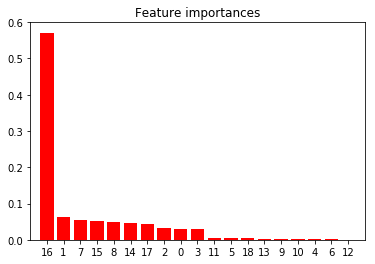

In [92]:
#feature importance
col_name=X_train.columns

indices = np.argsort(features)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [87]:
print(indices)
features_indexs=[]
combinatio=dict(zip(range(0,len(col_name)),col_name))
indices=indices.tolist()
for i in range(0,len(indices)):
    a=indices.pop()
    feature=combinatio[a]
    #print(feature)
    features_indexs.append(feature)
features_indexs=features_indexs[::-1]
print(features_indexs)

[16  1  7 15  8 14 17  2  0  3 11  5 18 13  9 10  4  6 12]
['mood', 'appCat.builtin', 'appCat.other', 'circumplex.valence', 'appCat.social', 'circumplex.arousal', 'screen', 'appCat.communication', 'activity', 'appCat.entertainment', 'appCat.utilities', 'appCat.game', 'sms', 'call', 'appCat.travel', 'appCat.unknown', 'appCat.finance', 'appCat.office', 'appCat.weather']


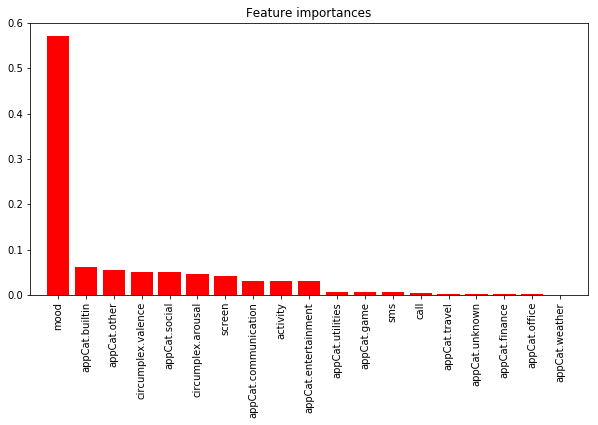

In [100]:
indices = np.argsort(features)[::-1]
#print(X_train.shape[1])
#print(len(features_indexs))
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), features_indexs,rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

# again random forest with now feature selection

In [102]:
#3 11  5 18 13  9 10  4  6 12 are dropped
y=data.iloc[:,-1]
x=data.iloc[:,2:21]
x=x.drop(x.columns[[3, 11,  5, 18, 13,  9, 10,  4,  6, 12]],axis=1)


In [106]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
prediction, features=rfr_model(X_train, X_test, y_train, y_test)
count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print(mean_squared_error(y_test,prediction))

C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 13, 'n_estimators': 100}
[0.08992087 0.08425621 0.08538454 0.09546822 0.07328847 0.08706202
 0.06775085 0.3323887  0.08448012]
percentage of correctly prediction: 0.6331360946745562


0.40537145945638764


### Benchmark

In [17]:
#prediction is the average mood of the previous 3 days
prediction=X_test.iloc[:,-3]
count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print(mean_squared_error(y_test,prediction))

percentage of correctly prediction: 0.5669642857142857


0.5012936899862825


## LASSO


In [7]:
def lasso_model(X_train, X_test, y_train, y_test):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=linear_model.Lasso(),
        param_grid={
            'alpha': (0.0001, 0.001, 0.5, 10),   
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    print(best_params)
    lasso = linear_model.Lasso(alpha=best_params["alpha"])                            
    #scores = cross_val_score(rfr, X, y, cv=3, scoring='neg_mean_absolute_error')
    #predictions = cross_val_predict(rfr, X, y, cv=10)
    model=lasso.fit(X_train, y_train)
    print(lasso.coef_)
    prediction=model.predict(X_test)
    return prediction, lasso.coef_

In [21]:
x=data.iloc[:,2:21]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
prediction, features=lasso_model(X_train, X_test, y_train, y_test)

count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print("mean squared error: \n")
print(mean_squared_error(y_test,prediction))

{'alpha': 0.001}
[ 2.97213579e-01  5.83603795e-04  9.71683197e-04  1.38321625e-04
  1.40984055e-03  8.12277205e-04  6.11726846e-04  9.38214176e-04
 -6.48680948e-04  3.81741353e-04 -1.04876577e-04  2.58927583e-03
  2.71302996e-03  3.82370607e-02  3.50847077e-02 -1.93141698e-01
  6.59070024e-01 -3.22502182e-04 -1.10657720e-01]
percentage of correctly prediction: 0.6420118343195266


mean squared error: 

0.42634352981041373


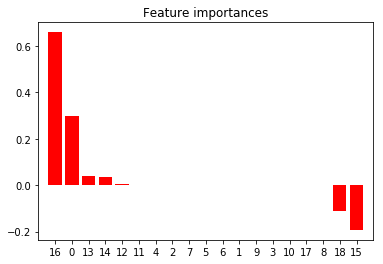

In [22]:
col_name=X_train.columns

indices = np.argsort(features)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()



## Again Lasso with now CV 

In [10]:
list_mse=[]
list_perf=[]
seed=111
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
for i, (index_train, index_test) in enumerate(kf.split(x)):
        #splitting the dataset and the labels following the indexes defined in Kfold
        X_train, X_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        prediction, features=lasso_model(X_train, X_test, y_train, y_test)
        performance=performance_cal(y_test,prediction)
        list_mse.append(mean_squared_error(y_test,prediction))
        list_perf.append(performance)
print("average mse: \n")
print(np.mean(list_mse))
print("average performance: \n")
print(np.mean(list_perf))

{'alpha': 0.001}
[ 3.07814844e-02  7.31306884e-04 -3.64814762e-04 -1.56174416e-04
  8.72438357e-04  8.28305513e-04  9.72983863e-05  1.78646575e-03
 -3.69169438e-04  3.80976557e-05  4.14376773e-04  3.63839102e-03
 -1.85728000e-03  6.18400679e-02 -1.49510749e-02 -1.70381009e-01
  6.64615315e-01  7.48738321e-05 -9.99915104e-02]
{'alpha': 0.001}
[ 5.06984742e-02  1.46261902e-03  8.08365683e-04  3.59229053e-05
  1.93584281e-03  8.11316198e-04  7.84413354e-04  1.82393349e-03
 -6.21562160e-04 -3.90023706e-04 -5.99198947e-05  2.67997847e-03
  1.79920307e-03  9.83926428e-02 -2.46817886e-02 -2.41176838e-01
  6.64433682e-01 -4.68710396e-04 -3.03552924e-02]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001}
[ 1.39536178e-01  5.44278150e-04  3.17876669e-04  3.59747392e-05
  4.73456008e-03  6.68374170e-04  3.01249156e-03  2.36134759e-03
 -5.41759153e-04 -4.37084113e-04 -1.57524221e-03  1.87216595e-03
  1.18666904e-03  7.18828995e-02 -2.47588709e-03 -2.45468319e-01
  6.83552277e-01 -3.92511333e-04 -1.61250976e-01]
{'alpha': 0.001}
[ 1.94702087e-01  4.18196724e-04  7.89056314e-04  2.94520792e-04
  3.88927732e-03  5.85853498e-04  5.54086559e-04  2.25459342e-03
 -6.04188144e-04 -1.02399602e-03 -6.73868703e-05  1.66145431e-03
 -5.05950663e-03  7.23547109e-03 -6.55498556e-03 -1.96423547e-01
  6.58722736e-01 -3.45617192e-04 -5.12959350e-02]
{'alpha': 0.001}
[ 4.00458625e-01  3.06287236e-04  5.75025337e-04 -1.53167516e-04
 -1.67884455e-03  7.71276164e-04  3.84040339e-04  2.13498664e-03
 -4.53080704e-04  5.41111907e-04 -3.92956686e-04  2.15668065e-03
  7.77303624e-03  1.49708301e-02  0.00000000e+00 -1.37463990e-01
  6.25920683e-01 -1.63482634e-04 -7.38272896e-02]
average mse: 

0.42

C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
print(indices)
features_indexs=[]
combinatio=dict(zip(range(0,len(col_name)),col_name))
indices=indices.tolist()
for i in range(0,len(indices)):
    a=indices.pop()
    feature=combinatio[a]
    #print(feature)
    features_indexs.append(feature)
features_indexs=features_indexs[::-1]
print(features_indexs)

[16  0 13 14 12 11  4  2  7  5  6  1  9  3 10 17  8 18 15]
['mood', 'activity', 'call', 'circumplex.arousal', 'appCat.weather', 'appCat.utilities', 'appCat.finance', 'appCat.communication', 'appCat.other', 'appCat.game', 'appCat.office', 'appCat.builtin', 'appCat.travel', 'appCat.entertainment', 'appCat.unknown', 'screen', 'appCat.social', 'sms', 'circumplex.valence']


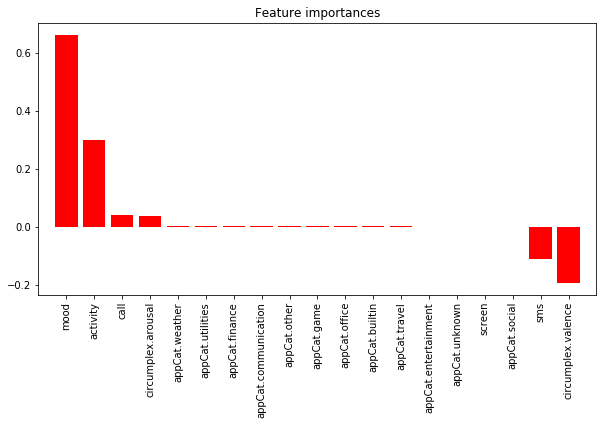

In [24]:
indices = np.argsort(features)[::-1]
#print(X_train.shape[1])
#print(len(features_indexs))
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), features_indexs,rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [34]:
x=data.iloc[:,2:21]
#x=x.drop(x.columns[[11,4,2,7,5,6,1,9,3,10,17,8]],axis=1)
scaler=MinMaxScaler(feature_range=(0,1))
x=scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
prediction, features=lasso_model(X_train, X_test, y_train, y_test)

count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print("mean squared error: \n")
print(mean_squared_error(y_test,prediction))

{'alpha': 0.001}
[ 0.14161755  0.12650383  0.         -0.10179204 -0.06572469  0.30035283
  0.          0.54781762 -0.28794778 -0.12154511  0.          0.07618474
 -0.          0.03807694 -0.11347218 -0.39044011  2.75704278 -0.0080875
 -0.07491553]
percentage of correctly prediction: 0.6242603550295858


mean squared error: 

0.40235577157080477


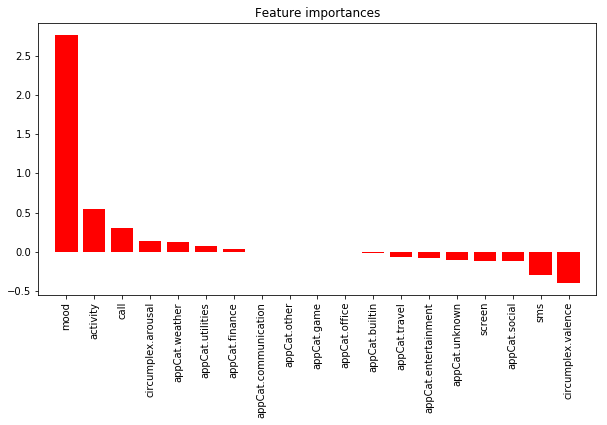

In [35]:
indices = np.argsort(features)[::-1]
#print(X_train.shape[1])
#print(len(features_indexs))
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), features_indexs,rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.001}
[ 1.54216145e-01  6.15110676e-04  1.51262425e-04 -1.70282082e-04
  2.56144547e-03  0.00000000e+00  5.53256671e-04  1.46292164e-03
 -5.94369259e-04 -1.14873930e-04 -2.12957189e-04  6.33064128e-03
  0.00000000e+00  1.76605104e-02  1.24826705e-02 -1.10836360e-01
  6.58888935e-01 -4.13308385e-04 -1.16633308e-01]
percentage of correctly prediction: 0.5888888888888889


mean squared error: 

0.40025207321655054


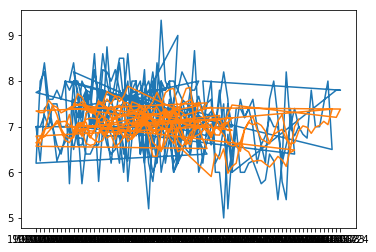

In [61]:
y=data.iloc[:,-1]
x=data.iloc[:,2:21]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40, shuffle=False)

prediction, features=lasso_model(X_train, X_test, y_train, y_test)

performance=performance_cal(y_test,prediction)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print("mean squared error: \n")
print(mean_squared_error(y_test,prediction))

dates=data.iloc[676:, 1]
# dates.shape
# y_test.shape
plt.plot(dates, y_test)
plt.plot(dates, prediction)
plt.show()

In [60]:
y_test.shape


(451,)